## Stable Diffusion (Text to Image) - Finetune with cat images (limited data)

#### Imports 

In [230]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [231]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.utils import name_from_base
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker import hyperparameters
from sagemaker import script_uris
from sagemaker import image_uris
from sagemaker import model_uris
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import datetime
import logging
import boto3
import json

##### Setup logging 

In [232]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### Log versions of dependencies 

In [233]:
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')

[Using SageMaker version: 2.145.0]
[Using SageMaker version: 2.145.0]
[Using SageMaker version: 2.145.0]
[Using SageMaker version: 2.145.0]
INFO:sagemaker:[Using SageMaker version: 2.145.0]


#### I. Setup essentials 

In [234]:
ROLE = get_execution_role()
REGION = boto3.Session().region_name
session = sagemaker.Session()
logger.info(f'Region: {REGION}')

Region: us-east-1
Region: us-east-1
Region: us-east-1
Region: us-east-1
INFO:sagemaker:Region: us-east-1


##### List all models from SageMaker JumpStart hub

In [235]:
# models = list_jumpstart_models()
# len(models)

In [236]:
# FILTER = 'task == txt2img'
# txt2img_models = list_jumpstart_models(filter=FILTER)
# txt2img_models

In [237]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [238]:
# model_version="*" fetches the latest version of the model
MODEL_ID, MODEL_VERSION = model_dropdown.value, "*"

In [239]:
# MODEL_ID = 'model-txt2img-stabilityai-stable-diffusion-v2-1-base'
# MODEL_VERSION = '*'  # latest
SCOPE = 'training'
TRAIN_INSTANCE_TYPE = 'ml.g4dn.2xlarge'

#### II. Deploy out of the box model and generate image of riobugger

In [240]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{MODEL_ID}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=MODEL_ID,
    model_version=MODEL_VERSION,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=MODEL_ID,
    model_version=MODEL_VERSION,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=MODEL_ID, model_version=MODEL_VERSION, model_scope="inference"
)

# To increase the maximum response size (in bytes) from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=ROLE,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# Deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

Creating model with name: jumpstart-example-infer-model-txt2img-s-2023-05-28-20-32-00-658
Creating model with name: jumpstart-example-infer-model-txt2img-s-2023-05-28-20-32-00-658
Creating model with name: jumpstart-example-infer-model-txt2img-s-2023-05-28-20-32-00-658
Creating model with name: jumpstart-example-infer-model-txt2img-s-2023-05-28-20-32-00-658
INFO:sagemaker:Creating model with name: jumpstart-example-infer-model-txt2img-s-2023-05-28-20-32-00-658
CreateModel request: {
    "ModelName": "jumpstart-example-infer-model-txt2img-s-2023-05-28-20-32-00-658",
    "ExecutionRoleArn": "arn:aws:iam::743783005718:role/service-role/AmazonSageMaker-ExecutionRole-20200502T085224",
    "PrimaryContainer": {
        "Image": "763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04",
        "Environment": {
            "MMS_MAX_RESPONSE_SIZE": "20000000"
        },
        "ModelDataUrl": "s3://jumpstart-cache-prod-us

----------!

In [241]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

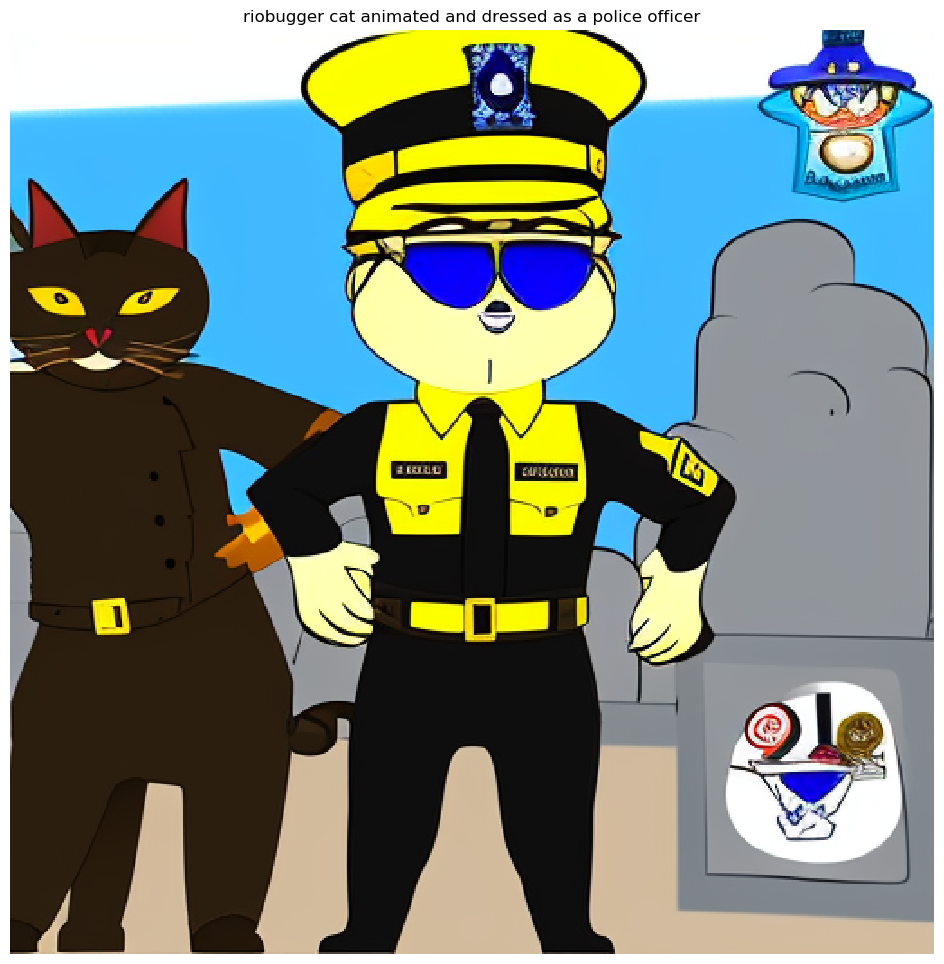

In [242]:
text = "riobugger cat animated and dressed as a police officer"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

#### III. Retrieve training artifacts 

In [243]:
train_image_uri = image_uris.retrieve(region=REGION, 
                                      framework=None,
                                      model_id=MODEL_ID, 
                                      model_version=MODEL_VERSION, 
                                      image_scope=SCOPE, 
                                      instance_type=TRAIN_INSTANCE_TYPE)
logger.info(f'Training image URI: {train_image_uri}')

image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
Training image URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
Training image URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
Training image URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
Training image URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training

In [244]:
train_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                        model_version=MODEL_VERSION, 
                                        script_scope=SCOPE)
logger.info(f'Training source URI: {train_source_uri}')

Training source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/prepack/v1.0.3/sourcedir.tar.gz
Training source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/prepack/v1.0.3/sourcedir.tar.gz
Training source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/prepack/v1.0.3/sourcedir.tar.gz
Training source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/prepack/v1.0.3/sourcedir.tar.gz
INFO:sagemaker:Training source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/prepack/v1.0.3/sourcedir.tar.gz


In [245]:
train_model_uri = model_uris.retrieve(model_id=MODEL_ID, 
                                      model_version=MODEL_VERSION, 
                                      model_scope=SCOPE)
logger.info(f'Training model URI: {train_model_uri}')

Training model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz
Training model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz
Training model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz
Training model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz
INFO:sagemaker:Training model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


##### Setup data locations 

In [246]:
DEFAULT_BUCKET = session.default_bucket()
logger.info(f'Default bucket = {DEFAULT_BUCKET}')

Default bucket = sagemaker-us-east-1-743783005718
Default bucket = sagemaker-us-east-1-743783005718
Default bucket = sagemaker-us-east-1-743783005718
Default bucket = sagemaker-us-east-1-743783005718
INFO:sagemaker:Default bucket = sagemaker-us-east-1-743783005718


In [247]:
TRAIN_DATA_INPUT_PREFIX = 'js-input/cats/'

In [248]:
TRAIN_DATA_INPUT_S3_PATH = f's3://{DEFAULT_BUCKET}/{TRAIN_DATA_INPUT_PREFIX}'
logger.info(f'Training data input S3 location => {TRAIN_DATA_INPUT_S3_PATH}')

Training data input S3 location => s3://sagemaker-us-east-1-743783005718/js-input/cats/
Training data input S3 location => s3://sagemaker-us-east-1-743783005718/js-input/cats/
Training data input S3 location => s3://sagemaker-us-east-1-743783005718/js-input/cats/
Training data input S3 location => s3://sagemaker-us-east-1-743783005718/js-input/cats/
INFO:sagemaker:Training data input S3 location => s3://sagemaker-us-east-1-743783005718/js-input/cats/


#### IV. Copy dataset for fine-tuning from local to S3

In [249]:
!rm -rf ./data/.ipynb_checkpoints/ 

In [250]:
!aws s3 cp ./data {TRAIN_DATA_INPUT_S3_PATH} --recursive

upload: data/dataset_info.json to s3://sagemaker-us-east-1-743783005718/js-input/cats/dataset_info.json
upload: data/riobugger1.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger1.jpeg
upload: data/riobugger3.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger3.jpeg
upload: data/riobugger5.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger5.jpeg
upload: data/riobugger2.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger2.jpeg
upload: data/riobugger7.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger7.jpeg
upload: data/riobugger8.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger8.jpeg
upload: data/riobugger4.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger4.jpeg
upload: data/riobugger6.jpeg to s3://sagemaker-us-east-1-743783005718/js-input/cats/riobugger6.jpeg


In [251]:
TRAIN_DATA_OUTPUT_PREFIX = 'js-output'
TRAIN_DATA_OUTPUT_S3_PATH = f's3://{DEFAULT_BUCKET}/{TRAIN_DATA_OUTPUT_PREFIX}'
logger.info(f'Training output S3 location => {TRAIN_DATA_OUTPUT_S3_PATH}')

Training output S3 location => s3://sagemaker-us-east-1-743783005718/js-output
Training output S3 location => s3://sagemaker-us-east-1-743783005718/js-output
Training output S3 location => s3://sagemaker-us-east-1-743783005718/js-output
Training output S3 location => s3://sagemaker-us-east-1-743783005718/js-output
INFO:sagemaker:Training output S3 location => s3://sagemaker-us-east-1-743783005718/js-output


#### V. Access and update default hyperparams

In [252]:
hyperparams = hyperparameters.retrieve_default(model_id=MODEL_ID, 
                                                   model_version=MODEL_VERSION)
hyperparams 

{'epochs': '20',
 'max_steps': 'None',
 'batch_size': '1',
 'with_prior_preservation': 'False',
 'num_class_images': '100',
 'learning_rate': '2e-06',
 'prior_loss_weight': '1.0',
 'center_crop': 'False',
 'lr_scheduler': 'constant',
 'adam_weight_decay': '0.01',
 'adam_beta1': '0.9',
 'adam_beta2': '0.999',
 'adam_epsilon': '1e-08',
 'gradient_accumulation_steps': '1',
 'max_grad_norm': '1.0',
 'compute_fid': 'False',
 'seed': '0'}

You can also override these hyperparams 

In [253]:
hyperparams['max_steps'] = '400'
hyperparams['seed'] = '123'
hyperparams

{'epochs': '20',
 'max_steps': '400',
 'batch_size': '1',
 'with_prior_preservation': 'False',
 'num_class_images': '100',
 'learning_rate': '2e-06',
 'prior_loss_weight': '1.0',
 'center_crop': 'False',
 'lr_scheduler': 'constant',
 'adam_weight_decay': '0.01',
 'adam_beta1': '0.9',
 'adam_beta2': '0.999',
 'adam_epsilon': '1e-08',
 'gradient_accumulation_steps': '1',
 'max_grad_norm': '1.0',
 'compute_fid': 'False',
 'seed': '123'}

#### VI. Finetune Stable Diffusion model

In [254]:
model_prefix = name_from_base(f'js-{MODEL_ID}-')
training_job_name = f'{model_prefix}-finetuning'
logger.info(f'Train job name => {training_job_name}')

Train job name => js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-327-finetuning
Train job name => js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-327-finetuning
Train job name => js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-327-finetuning
Train job name => js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-327-finetuning
INFO:sagemaker:Train job name => js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-327-finetuning


In [255]:
MAX_RUN = 360000

In [256]:
estimator = Estimator(role=ROLE, 
                      image_uri=train_image_uri, 
                      source_dir=train_source_uri, 
                      model_uri=train_model_uri, 
                      entry_point='transfer_learning.py', 
                      instance_count=1, 
                      instance_type=TRAIN_INSTANCE_TYPE, 
                      max_run=MAX_RUN, 
                      hyperparameters=hyperparams, 
                      output_path=TRAIN_DATA_OUTPUT_S3_PATH, 
                      base_job_name=training_job_name)

In [ ]:
%%time

estimator.fit({'training': TRAIN_DATA_INPUT_S3_PATH}, logs=False)

Creating training-job with name: js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-548
Creating training-job with name: js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-548
Creating training-job with name: js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-548
Creating training-job with name: js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-548
INFO:sagemaker:Creating training-job with name: js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-548
train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04"
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-743783005718/js-output"
    },
    "TrainingJobName": "js-model-txt2img-stabilityai-stable-dif-2023-05-28-20-37-50-548",
    "StoppingCondition": {
        "MaxRuntimeInSeconds"


2023-05-28 20:37:51 Starting - Starting the training job.
2023-05-28 20:38:05 Starting - Preparing the instances for training.............
2023-05-28 20:39:13 Downloading - Downloading input data.......................
2023-05-28 20:41:13 Training - Downloading the training image....................................................................................................................................
2023-05-28 20:54:52 Uploading - Uploading generated training model..............................................................................
2023-05-28 21:04:34 Completed - Training job completed
CPU times: user 1.31 s, sys: 152 ms, total: 1.47 s
Wall time: 26min 46s


#### VII. Deploy fine-tuned model as a SageMaker endpoint

##### Retrieve artifacts for inference 

In [274]:
SCOPE = 'inference'
INFERENCE_INSTANCE_TYPE = 'ml.g4dn.2xlarge'  # prefered

In [275]:
deploy_image_uri = image_uris.retrieve(region=REGION, 
                                       framework=None,  
                                       image_scope=SCOPE, 
                                       model_id=MODEL_ID, 
                                       model_version=MODEL_VERSION, 
                                       instance_type=INFERENCE_INSTANCE_TYPE)
logger.info(f'Deploy image URI => {deploy_image_uri}')

Deploy image URI => 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
Deploy image URI => 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
Deploy image URI => 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
Deploy image URI => 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
INFO:sagemaker:Deploy image URI => 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [276]:
deploy_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                         model_version=MODEL_VERSION, 
                                         script_scope=SCOPE)
logger.info(f'Deploy source URI => {deploy_source_uri}')

Deploy source URI => s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz
Deploy source URI => s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz
Deploy source URI => s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz
Deploy source URI => s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz
INFO:sagemaker:Deploy source URI => s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz


In [277]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
endpoint_name = f'js-ep-{current_time}'
endpoint_name 

'js-ep-20230528211958'

In [ ]:
%%time

predictor = estimator.deploy(initial_instance_count=1, 
                             instance_type=INFERENCE_INSTANCE_TYPE, 
                             entry_point='inference.py', 
                             image_uri=deploy_image_uri, 
                             source_dir=deploy_source_uri, 
                             endpoint_name=endpoint_name)

---------!CPU times: user 5min 28s, sys: 45.8 s, total: 6min 14s
Wall time: 11min 18s


#### VIII. Invoke the endpoint for inference using Predictor 

In [296]:
prompt = 'riobugger cat animated and dressed as a police officer'

In [297]:
prompt = json.dumps(prompt).encode('utf-8')

In [298]:
MIME_INFO = {'ContentType': 'application/x-text', 
             'Accept': 'application/json'}

In [299]:
%%time

response = predictor.predict(prompt, MIME_INFO)

CPU times: user 21.1 ms, sys: 720 µs, total: 21.9 ms
Wall time: 24.5 s


In [300]:
response = json.loads(response)
img = response['generated_image']
prompt = response['prompt']

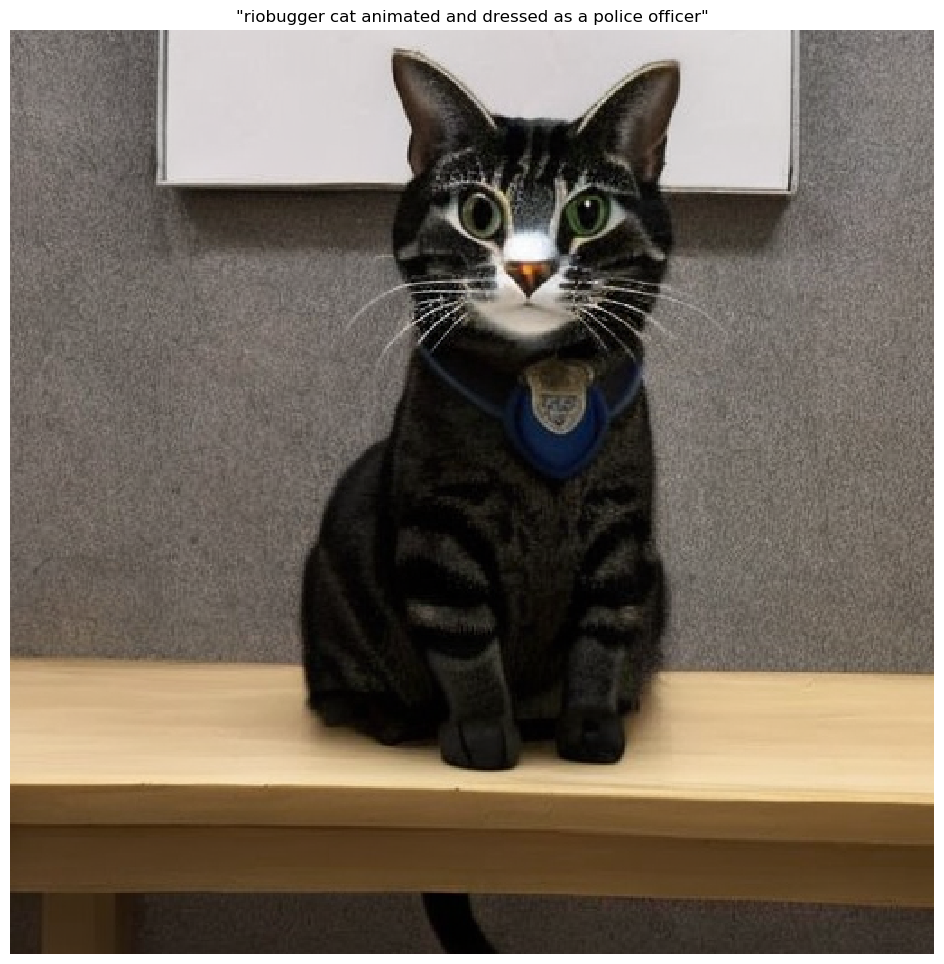

In [301]:
plt.figure(figsize=(12, 12))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(prompt)
plt.show()

#### VIII. Invoke the endpoint for inference using SageMaker run-time client (Alternative)

In [317]:
prompt = 'cartoon animated riobugger cat dressed as a police officer'

In [318]:
client = boto3.client('sagemaker-runtime')

In [319]:
%%time

response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                  Body=prompt, 
                                  ContentType='application/x-text')

CPU times: user 14.4 ms, sys: 326 µs, total: 14.7 ms
Wall time: 23.7 s


In [320]:
response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

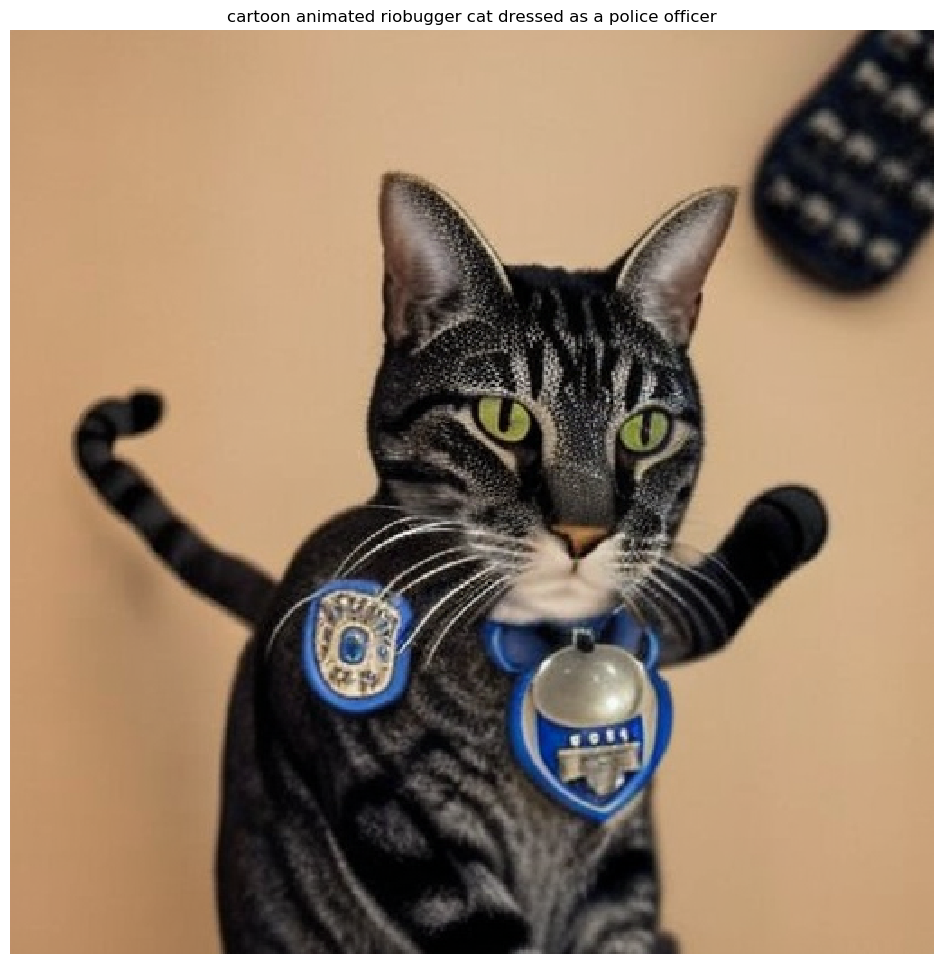

In [321]:
plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()

In [ ]:
# Delete endpoint to save costs
# predictor.delete_endpoint()